In [53]:
#!pip install tensorflow
#!pip install keras
#!pip install gensim


In [118]:
#librerías, no es necesario volverlas a importar

import pandas as pd
import os
import gc
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import multiprocessing
from collections import Counter

from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer


from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers, Sequential

from gensim.models import Word2Vec

%run ../0_Data/0_DataLoader.ipynb

[nltk_data] Downloading package punkt to /home/celeste/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/celeste/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/celeste/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# 1. Datos

In [7]:
x_train_original, train_y = get_train_x_y_original()

x_test_original = get_test_x_original()

x_train_preprocesado = preprocesar_data (x_train_original, clean_text_sentiment_analysis)

x_test_preprocesado = preprocesar_data (x_test_original, clean_text_sentiment_analysis)

In [4]:
x_train_preprocesado.head()

id
1    our deed are the reason of this earthquak may ...
4                 forest fire near la rong sask canada
5    all resid ask to shelter in place are be notif...
6    13000 peopl receiv wildfir evacu order in cali...
7    just got sent this photo from rubi alaska as s...
Name: text, dtype: object

In [8]:
x_test_preprocesado.head()

id
0                       just happen a terribl car crash
2     heard about earthquak is differ citi stay safe...
3     there is a forest fire at spot pond gees are f...
9                        apocalyps light spokan wildfir
11         typhoon soudelor kill 28 in china and taiwan
Name: text, dtype: object

id
1    our deed are the reason of this may allah forg...
4                 forest fire near la rong sask canada
5    all resid ask to shelter in place are be notif...
6         13000 peopl receiv evacu order in california
7    just got sent this photo from rubi as smoke fr...
Name: texto_preprocesado, dtype: object

# 2. Embeddings sin preentrenar

In [122]:
def plot_history(history):
    acc = history.history['accuracy']
    loss = history.history['loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.plot(x, acc, 'r', label='Training acc')
    plt.plot(x, loss, 'b', label='Training loss')
    plt.title('Training accuracy vs loss')
    plt.legend()

In [5]:
## some config values 
embed_size = 300 # how big is each word vector
max_features = 50000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 200 # max number of words in a question to use


In [26]:
def liberar_memoria (var):
    del var
    gc.collect()
    sleep(10)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 200, 300)          15000000  
_________________________________________________________________
flatten_4 (Flatten)          (None, 60000)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)                600010    
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 11        
Total params: 15,600,021
Trainable params: 15,600,021
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
15/15 [==============================] - ETA: 0s - loss: 0.6909 - accuracy: 0.59 - ETA: 1s - loss: 0.7162 - accuracy: 0.58 - ETA: 2s - loss: 0.7084 - accuracy: 0.54 - ETA: 1s - loss: 0.7030 - accuracy: 0.55 - ETA: 1s - loss: 0.69

Training Accuracy: 0.9953


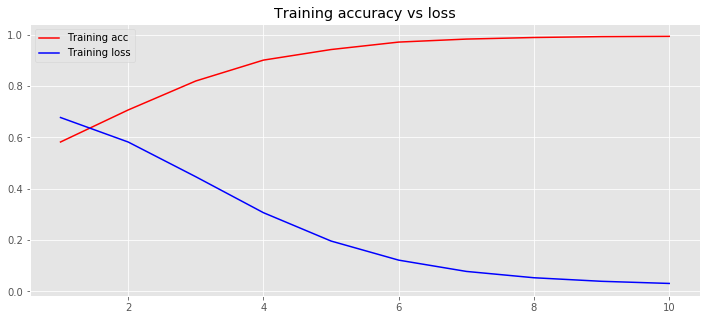

In [41]:
## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(x_train_original))
train_X = tokenizer.texts_to_sequences(x_train_original)

## Pad the sentences 
train_X = pad_sequences(train_X, maxlen=maxlen)

model = Sequential()
model.add(layers.Embedding(input_dim=max_features, 
                           output_dim=embed_size, 
                           input_length=maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

history = model.fit(train_X, train_y,
                    epochs=10,
                    batch_size=512)


loss, accuracy = model.evaluate(train_X, train_y, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
plot_history(history)

In [97]:
liberar_memoria(model)

In [42]:
test_X = tokenizer.texts_to_sequences(x_test_original)

## Pad the sentences 
test_X = pad_sequences(test_X, maxlen=maxlen)


#y_test = model.predict(test_X, batch_size=1024, verbose=1)
#y_test = model.predict_classes(test_X, batch_size=1024, verbose=1)

y_test = (model.predict(test_X, batch_size=1024, verbose=1) > 0.5).astype("int32")

4/4 [==============================] - ETA:  - ETA:  - ETA:  - 0s 37ms/step


In [43]:
pred_y = model.predict_classes(train_X, batch_size=1024, verbose=1)
print("Report: \n{}".format(classification_report(train_y, pred_y)))

8/8 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 52ms/step


Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4342
           1       0.99      1.00      0.99      3271

    accuracy                           1.00      7613
   macro avg       1.00      1.00      1.00      7613
weighted avg       1.00      1.00      1.00      7613



In [45]:
pred_y

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]], dtype=int32)

In [46]:
submission = pd.read_csv(os.path.join('..','0_Data','dataset','sample_submission.csv'))
submission['target'] = y_test
submission.to_csv("submission2.csv", index=False)

In [47]:
len(y_test)

3263

In [14]:
submission

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0
...,...,...
3258,10861,0
3259,10865,0
3260,10868,0
3261,10874,1


# 3. Embeddings preentrenados

In [124]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer

In [123]:
liberar_memoria(w2v_model)

Time to build vocab: 0.0 mins
Time to train the model: 0.05 mins
Number of word vectors: 1210
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 300)          15000000  
_________________________________________________________________
flatten_2 (Flatten)          (None, 60000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                600010    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 15,600,021
Trainable params: 15,600,021
Non-trainable params: 0
_________________________________________________________________
Shape of data tensor: (7613, 200)
Epoch 1/10
15/15 [==============================] - 3s 200ms/step - loss: 0.6898 - accuracy: 0.5698
Epoch 2/10
1

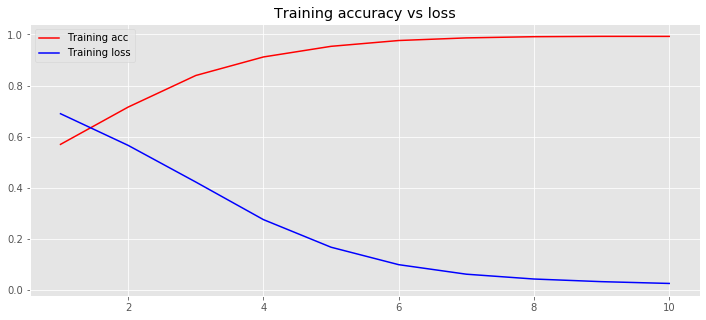

In [127]:
## some config values 
embed_size = 300 # how big is each word vector
max_features = 50000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 200 # max number of words in a tweet to use

## obtengo el vocabulario
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(x_train_original)+ list(x_test_original))

## indice del vocabulario
word_index = tokenizer.word_index

## para proecesarlo necesito una lista de palabras por  tweet
tweets_list_train = [text_to_word_sequence(sentence) for sentence in x_train_original]
tweets_list_test = [text_to_word_sequence(sentence) for sentence in x_test_original]
tweets_all = tweets_list_train + tweets_list_test

## creo el modelo de word2vec
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=embed_size,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

## se genera el vocabulario

t = time()

w2v_model.build_vocab(tweets_all, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

# se entrena el modelo word2vec

t = time()

w2v_model.train(tweets_all, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

word_vectors = w2v_model.wv

print("Number of word vectors: {}".format(len(word_vectors.vocab)))

MAX_NB_WORDS = len(word_vectors.vocab)

wv_matrix = (np.random.rand(MAX_NB_WORDS, embed_size) - 0.5) / 5.0
for word, i in word_index.items():
    if i >= MAX_NB_WORDS:
        continue
    try:
        embedding_vector = word_vectors[word]
        # words not found in embedding index will be all-zeros.
        wv_matrix[i] = embedding_vector
    except:
        pass    
    

model2 = Sequential()
model2.add(layers.Embedding(input_dim=max_features, 
                           output_dim=embed_size, 
                           input_length=maxlen))
model2.add(layers.Flatten())
model2.add(layers.Dense(10, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model2.summary()

train_X = tokenizer.texts_to_sequences(x_train_original)

# pad
train_X = pad_sequences(train_X, maxlen=maxlen, 
                     padding="pre", truncating="post")

print('Shape of data tensor:', train_X.shape)

history2 = model2.fit(train_X, train_y,
                    epochs=10,
                    batch_size=512)


loss, accuracy = model2.evaluate(train_X, train_y, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
plot_history(history2)

In [129]:
pred_y = model2.predict_classes(train_X, batch_size=1024, verbose=1)
print("Report: \n{}".format(classification_report(train_y, pred_y)))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
8/8 [==============================] - 0s 50ms/step
Report: 
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4342
           1       1.00      0.99      0.99      3271

    accuracy                           0.99      7613
   macro avg       0.99      0.99      0.99      7613
weighted avg       0.99      0.99      0.99      7613



In [131]:
test_X = tokenizer.texts_to_sequences(x_test_original)

## Pad the sentences 
test_X = pad_sequences(test_X, maxlen=maxlen)

y_test = (model2.predict(test_X, batch_size=1024, verbose=1) > 0.5).astype("int32")

4/4 [==============================] - 0s 35ms/step


In [132]:
submission = pd.read_csv(os.path.join('..','0_Data','dataset','sample_submission.csv'))
submission['target'] = y_test
submission.to_csv("submission3.csv", index=False)